In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action = 'ignore')

In [4]:
# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

In [5]:
df_good = pd.read_csv('./dataset/data_확장기.csv')
df_bad = pd.read_csv('./dataset/data_수축기.csv')
df_change = pd.read_csv('./dataset/data_전환기.csv')
df_all = pd.read_csv('./dataset/data_전체.csv')

df_good.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_bad.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_change.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_all.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)

#### 함수

##### train, test 분리, 데이터 불균형 처리, 스케일링

In [6]:
def data(df):
    # scaler : StandardScaler(), RobustScaler()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    
    X_train, y_train = RandomUnderSampler(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    # X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)

    # X_train, y_train = BorderlineSMOTE(random_state=121, sampling_strategy = 'not majority').fit_resample(X_train, y_train)
    # X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [7]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [8]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### 모델링

In [9]:
def LR(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()

    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

In [10]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [11]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

In [12]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

#### Feature Selection

In [13]:
rfe_good = df_good[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '유형자산증가율', '순이익증가율', 'target']]
sfm_rf_good = df_good[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_good = df_good[['자기자본비율', '차입금의존도', '총자산이익률', '총자본경상이익률', '자기자본영업이익률', '매출원가율', '총자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_good = df_good[['자기자본영업이익률', '총자본회전율', '총자산이익률', '총자본경상이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

In [14]:
rfe_bad = df_bad[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', 'target']]
sfm_rf_bad = df_bad[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_bad = df_bad[['자기자본비율', '유동비율', '차입금의존도', '자기자본영업이익률', '매출원가율', '총자본회전율', '자기자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_bad = df_bad[['자기자본영업이익률', '총자본회전율', '총자본경상이익률', '총자산이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

#### 확장기

##### Recursive Feature Elimination

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8450812512952997

예측 데이터 정확도
accuracy score : 0.799
precision score : 0.329
recall score : 0.873
f1 score : 0.478
roc score : 0.831


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.24591    0.12266 0.99812   0.21847    0.57761
0.30000   0.43299    0.15585 0.98934   0.26927    0.67832
0.40000   0.64286    0.22191 0.95044   0.35981    0.77849
0.50000   0.79901    0.32946 0.87265   0.47834    0.83148
0.60000   0.85207    0.36422 0.53764   0.43425    0.71342
0.70000   0.86499    0.32764 0.26474   0.29285    0.60030
0.80000   0.87811    0.30538 0.12108   0.17341    0.54428
0.90000   0.89440    0.00000 0.00000   0.00000    0.50000
None


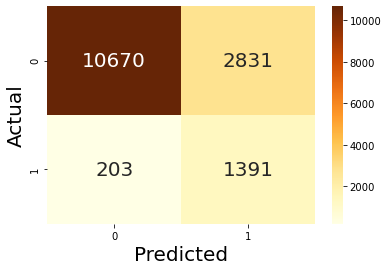

In [15]:
LR(rfe_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9020774975567767

예측 데이터 정확도
accuracy score : 0.864
precision score : 0.434
recall score : 0.938
f1 score : 0.593
roc score : 0.897
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80543    0.35121 0.99435   0.51908    0.88874
0.30000   0.83445    0.38707 0.97302   0.55383    0.89556
0.40000   0.85485    0.41829 0.95859   0.58243    0.90060
0.50000   0.86413    0.43371 0.93789   0.59314    0.89666
0.60000   0.87850    0.46212 0.91844   0.61487    0.89612
0.70000   0.87850    0.46198 0.91468   0.61389    0.89446
0.80000   0.89771    0.50999 0.80050   0.62305    0.85485
0.90000   0.91136    0.59078 0.52258   0.55459    0.73992
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

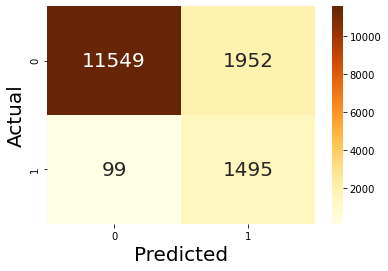

In [16]:
DT(rfe_good)

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.48335724182778517

예측 데이터 정확도
accuracy score : 0.870
precision score : 0.442
recall score : 0.895
f1 score : 0.592
roc score : 0.881


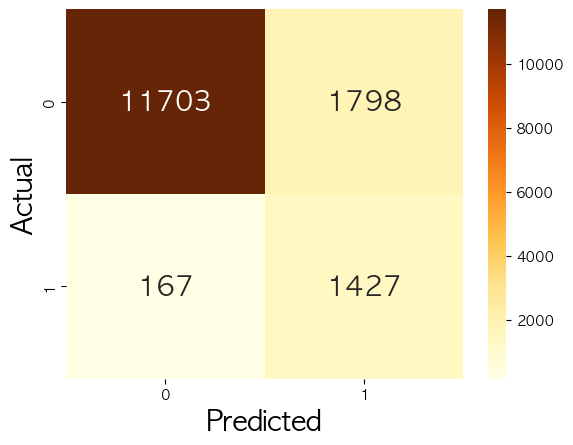

In [27]:
SVM(rfe_good, 'rbf')

In [17]:
XGB(rfe_good)

KeyboardInterrupt: 

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8449950986523687

예측 데이터 정확도
accuracy score : 0.799
precision score : 0.329
recall score : 0.873
f1 score : 0.478
roc score : 0.831
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.24598    0.12267 0.99812   0.21848    0.57765
0.30000   0.43299    0.15585 0.98934   0.26927    0.67832
0.40000   0.64306    0.22201 0.95044   0.35994    0.77860
0.50000   0.79901    0.32946 0.87265   0.47834    0.83148
0.60000   0.85207    0.36422 0.53764   0.43425    0.71342
0.70000   0.86499    0.32764 0.26474   0.29285    0.60030
0.80000   0.87811    0.30538 0.12108   0.17341    0.54428
0.90000   0.89440    0.00000 0.00000   0.00000    0.50000
None


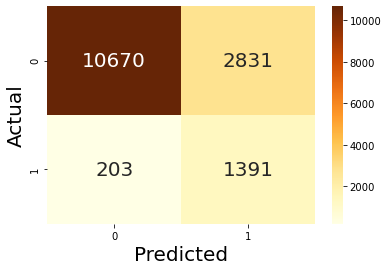

In [18]:
LR(sfm_rf_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9040415216234345

예측 데이터 정확도
accuracy score : 0.851
precision score : 0.412
recall score : 0.969
f1 score : 0.578
roc score : 0.903
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80636    0.35237 0.99498   0.52043    0.88954
0.30000   0.81232    0.35904 0.98996   0.52697    0.89066
0.40000   0.85061    0.41184 0.96863   0.57795    0.90266
0.50000   0.85061    0.41184 0.96863   0.57795    0.90266
0.60000   0.87738    0.46047 0.93915   0.61796    0.90462
0.70000   0.88804    0.48385 0.90213   0.62987    0.89426
0.80000   0.90109    0.51995 0.82560   0.63806    0.86780
0.90000   0.91249    0.60194 0.50565   0.54961    0.73308
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

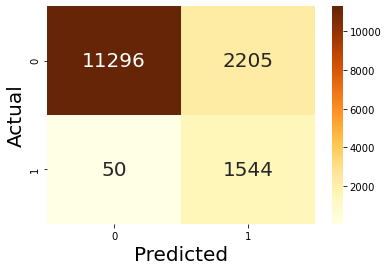

In [19]:
DT(sfm_rf_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8901476495975944

예측 데이터 정확도
accuracy score : 0.842
precision score : 0.395
recall score : 0.935
f1 score : 0.556
roc score : 0.883


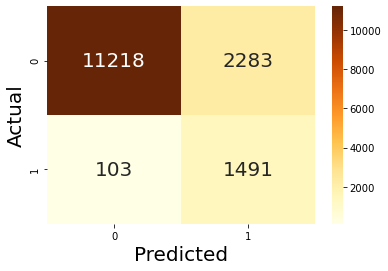

In [21]:
SVM(sfm_rf_good, 'rbf')

In [40]:
XGB(sfm_rf_good)

KeyboardInterrupt: 

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8449950986523687

예측 데이터 정확도
accuracy score : 0.799
precision score : 0.329
recall score : 0.873
f1 score : 0.478
roc score : 0.831
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.24591    0.12266 0.99812   0.21847    0.57761
0.30000   0.43299    0.15585 0.98934   0.26927    0.67832
0.40000   0.64306    0.22201 0.95044   0.35994    0.77860
0.50000   0.79901    0.32946 0.87265   0.47834    0.83148
0.60000   0.85207    0.36422 0.53764   0.43425    0.71342
0.70000   0.86499    0.32764 0.26474   0.29285    0.60030
0.80000   0.87811    0.30538 0.12108   0.17341    0.54428
0.90000   0.89440    0.00000 0.00000   0.00000    0.50000
None


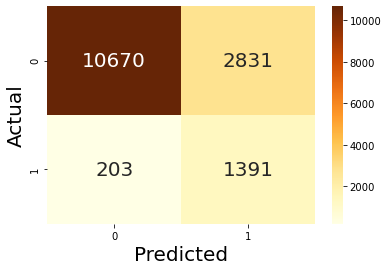

In [22]:
LR(sfm_lr_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9002498160547419

예측 데이터 정확도
accuracy score : 0.805
precision score : 0.352
recall score : 0.999
f1 score : 0.520
roc score : 0.891
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80503    0.35127 0.99937   0.51982    0.89073
0.30000   0.80503    0.35127 0.99937   0.51982    0.89073
0.40000   0.80537    0.35166 0.99937   0.52025    0.89092
0.50000   0.80537    0.35166 0.99937   0.52025    0.89092
0.60000   0.83942    0.39027 0.92597   0.54911    0.87759
0.70000   0.86360    0.42682 0.85069   0.56843    0.85791
0.80000   0.89268    0.49450 0.73275   0.59050    0.82215
0.90000   0.90891    0.62262 0.34881   0.44713    0.66192
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

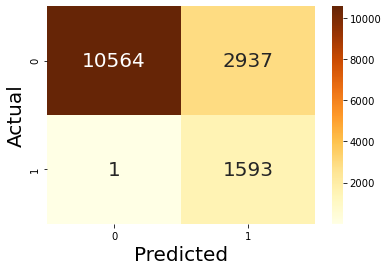

In [23]:
DT(sfm_lr_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8841057217340131

예측 데이터 정확도
accuracy score : 0.807
precision score : 0.350
recall score : 0.965
f1 score : 0.513
roc score : 0.877


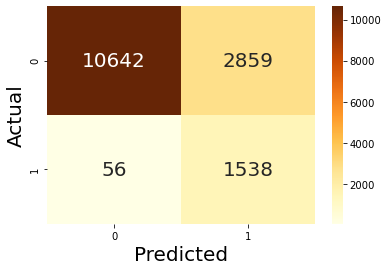

In [24]:
SVM(sfm_lr_good, 'rbf')

In [ ]:
XGB(sfm_lr_good)

##### Permutation Importance

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8450812512952997

예측 데이터 정확도
accuracy score : 0.799
precision score : 0.329
recall score : 0.873
f1 score : 0.478
roc score : 0.831
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.24591    0.12266 0.99812   0.21847    0.57761
0.30000   0.43299    0.15585 0.98934   0.26927    0.67832
0.40000   0.64306    0.22201 0.95044   0.35994    0.77860
0.50000   0.79901    0.32946 0.87265   0.47834    0.83148
0.60000   0.85207    0.36422 0.53764   0.43425    0.71342
0.70000   0.86499    0.32764 0.26474   0.29285    0.60030
0.80000   0.87811    0.30538 0.12108   0.17341    0.54428
0.90000   0.89440    0.00000 0.00000   0.00000    0.50000
None


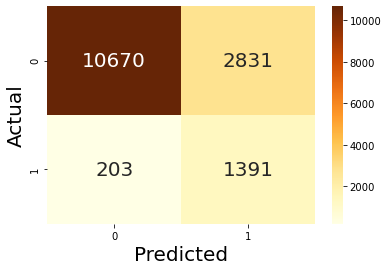

In [25]:
LR(sfm_pi_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9018603663801672

예측 데이터 정확도
accuracy score : 0.863
precision score : 0.433
recall score : 0.954
f1 score : 0.596
roc score : 0.903
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80530    0.35164 1.00000   0.52032    0.89116
0.30000   0.80530    0.35164 1.00000   0.52032    0.89116
0.40000   0.84154    0.39769 0.97302   0.56462    0.89952
0.50000   0.86327    0.43309 0.95420   0.59577    0.90337
0.60000   0.87387    0.45257 0.92785   0.60839    0.89767
0.70000   0.87970    0.46440 0.90841   0.61460    0.89236
0.80000   0.90666    0.54195 0.74969   0.62911    0.83744
0.90000   0.91507    0.64857 0.42723   0.51513    0.69995
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

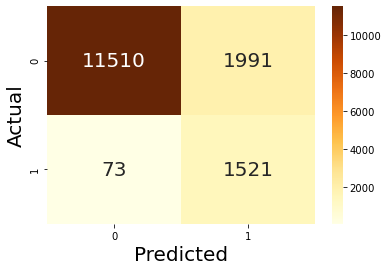

In [26]:
DT(sfm_pi_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.889069341472454

예측 데이터 정확도
accuracy score : 0.839
precision score : 0.390
recall score : 0.924
f1 score : 0.548
roc score : 0.877


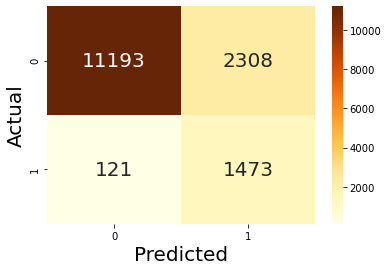

In [27]:
SVM(sfm_pi_good, 'rbf')

In [ ]:
XGB(sfm_pi_good)

#### 수축기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8318599730011769

예측 데이터 정확도
accuracy score : 0.779
precision score : 0.262
recall score : 0.882
f1 score : 0.404
roc score : 0.826
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.44389    0.13168 0.98992   0.23244    0.69152
0.30000   0.59171    0.16896 0.96975   0.28778    0.76316
0.40000   0.70536    0.21655 0.94118   0.35209    0.81231
0.50000   0.77884    0.26224 0.88235   0.40431    0.82579
0.60000   0.82845    0.29820 0.75126   0.42693    0.79344
0.70000   0.85718    0.29880 0.50420   0.37523    0.69710
0.80000   0.87462    0.27619 0.29244   0.28408    0.61059
0.90000   0.89278    0.22222 0.10420   0.14188    0.53515
None


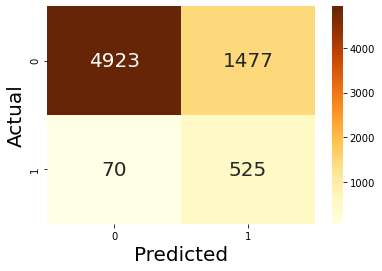

In [28]:
LR(rfe_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.8851150875953231

예측 데이터 정확도
accuracy score : 0.777
precision score : 0.274
recall score : 0.982
f1 score : 0.428
roc score : 0.870
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.77012    0.26925 0.99328   0.42366    0.87133
0.30000   0.77012    0.26925 0.99328   0.42366    0.87133
0.40000   0.77012    0.26925 0.99328   0.42366    0.87133
0.50000   0.77713    0.27392 0.98151   0.42831    0.86982
0.60000   0.77898    0.27238 0.95630   0.42399    0.85940
0.70000   0.87663    0.38428 0.74790   0.50770    0.81825
0.80000   0.89635    0.42794 0.64874   0.51570    0.78406
0.90000   0.91623    0.51002 0.38487   0.43870    0.67525
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

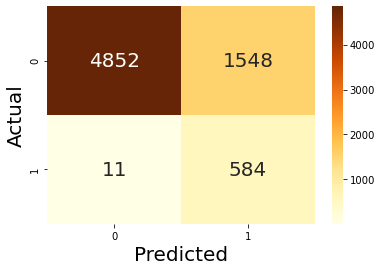

In [29]:
DT(rfe_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8634511083800411

예측 데이터 정확도
accuracy score : 0.782
precision score : 0.274
recall score : 0.943
f1 score : 0.424
roc score : 0.855


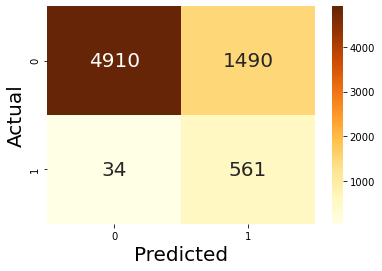

In [30]:
SVM(rfe_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.4673111692704167

예측 데이터 정확도
accuracy score : 0.911
precision score : 0.485
recall score : 0.671
f1 score : 0.563
roc score : 0.802
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.86590    0.37688 0.88235   0.52817    0.87336
0.30000   0.88692    0.41508 0.80504   0.54774    0.84979
0.40000   0.90093    0.45020 0.74454   0.56111    0.83000
0.50000   0.91137    0.48481 0.67059   0.56276    0.80217
0.60000   0.91580    0.50445 0.57143   0.53586    0.75962
0.70000   0.92037    0.53740 0.45882   0.49501    0.71105
0.80000   0.92423    0.59760 0.33445   0.42888    0.65676
0.90000   0.92309    0.68627 0.17647   0.28075    0.58449
None


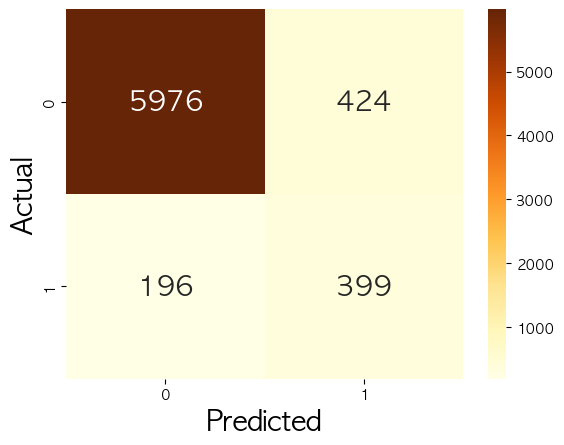

In [ ]:
XGB(rfe_bad)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8344867466256103

예측 데이터 정확도
accuracy score : 0.787
precision score : 0.271
recall score : 0.886
f1 score : 0.414
roc score : 0.832
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.44703    0.13200 0.98655   0.23284    0.69171
0.30000   0.59543    0.17045 0.97143   0.29002    0.76595
0.40000   0.71237    0.22073 0.94118   0.35760    0.81614
0.50000   0.78713    0.27053 0.88571   0.41447    0.83184
0.60000   0.83731    0.31027 0.74622   0.43830    0.79600
0.70000   0.86319    0.31568 0.52101   0.39315    0.70800
0.80000   0.87748    0.28871 0.30084   0.29465    0.61597
0.90000   0.89350    0.23404 0.11092   0.15051    0.53859
None


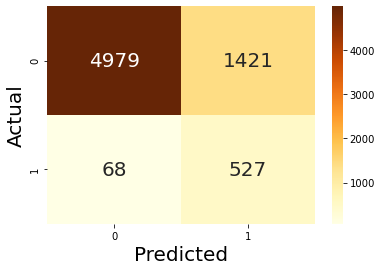

In [31]:
LR(sfm_rf_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.8829180351086532

예측 데이터 정확도
accuracy score : 0.845
precision score : 0.344
recall score : 0.911
f1 score : 0.500
roc score : 0.875
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.77312    0.27164 0.99160   0.42645    0.87220
0.30000   0.78642    0.28232 0.97983   0.43835    0.87413
0.40000   0.79585    0.29144 0.97815   0.44907    0.87853
0.50000   0.84489    0.34435 0.91092   0.49977    0.87484
0.60000   0.86276    0.37139 0.88571   0.52334    0.87317
0.70000   0.87634    0.39486 0.85210   0.53965    0.86535
0.80000   0.88006    0.39713 0.79160   0.52892    0.83994
0.90000   0.91008    0.47665 0.58319   0.52457    0.76183
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

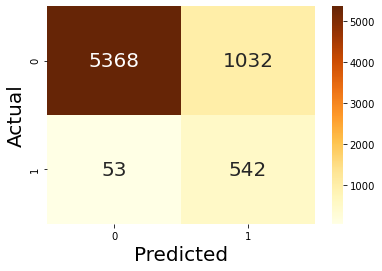

In [32]:
DT(sfm_rf_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8741063962052955

예측 데이터 정확도
accuracy score : 0.794
precision score : 0.287
recall score : 0.956
f1 score : 0.441
roc score : 0.868


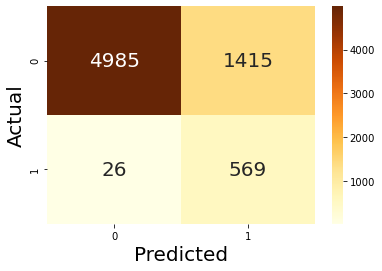

In [33]:
SVM(sfm_rf_bad, 'rbf')

In [ ]:
XGB(sfm_rf_bad)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8218550494498867

예측 데이터 정확도
accuracy score : 0.787
precision score : 0.264
recall score : 0.840
f1 score : 0.402
roc score : 0.811
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.42059    0.12721 0.99160   0.22549    0.67955
0.30000   0.59786    0.17150 0.97311   0.29161    0.76804
0.40000   0.71723    0.22285 0.93445   0.35987    0.81574
0.50000   0.78742    0.26427 0.84034   0.40209    0.81142
0.60000   0.82931    0.28592 0.67227   0.40120    0.75809
0.70000   0.85375    0.29696 0.52605   0.37962    0.70513
0.80000   0.86762    0.22463 0.22689   0.22575    0.57704
0.90000   0.89121    0.20979 0.10084   0.13621    0.53276
None


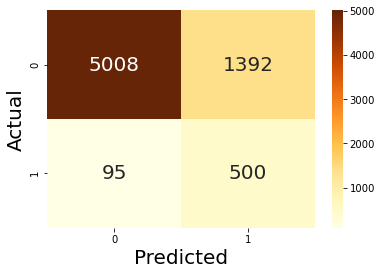

In [34]:
LR(sfm_lr_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.8870517759467165

예측 데이터 정확도
accuracy score : 0.782
precision score : 0.277
recall score : 0.971
f1 score : 0.432
roc score : 0.868
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.76926    0.26914 0.99832   0.42398    0.87314
0.30000   0.76926    0.26914 0.99832   0.42398    0.87314
0.40000   0.76998    0.26892 0.99160   0.42309    0.87049
0.50000   0.78227    0.27735 0.97143   0.43150    0.86806
0.60000   0.78227    0.27735 0.97143   0.43150    0.86806
0.70000   0.87291    0.37542 0.74454   0.49915    0.81469
0.80000   0.90279    0.44668 0.59832   0.51149    0.76471
0.90000   0.91523    0.50164 0.51429   0.50788    0.73339
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

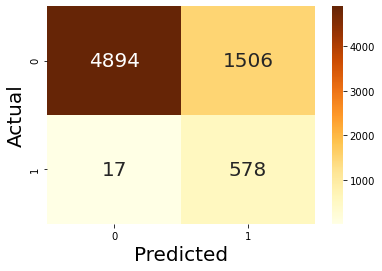

In [35]:
DT(sfm_lr_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8651683184017163

예측 데이터 정확도
accuracy score : 0.775
precision score : 0.269
recall score : 0.956
f1 score : 0.419
roc score : 0.857


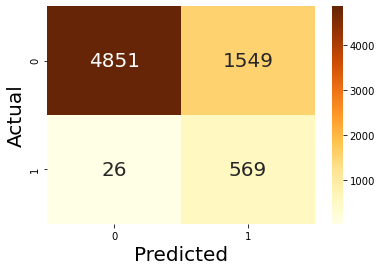

In [36]:
SVM(sfm_lr_bad, 'rbf')

In [ ]:
XGB(sfm_lr_bad)

##### Permutation Importance

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8336802950127071

예측 데이터 정확도
accuracy score : 0.786
precision score : 0.269
recall score : 0.884
f1 score : 0.412
roc score : 0.830
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.44618    0.13182 0.98655   0.23257    0.69125
0.30000   0.59428    0.17005 0.97143   0.28943    0.76532
0.40000   0.71122    0.22004 0.94118   0.35669    0.81551
0.50000   0.78570    0.26892 0.88403   0.41239    0.83030
0.60000   0.83674    0.31020 0.75126   0.43910    0.79797
0.70000   0.86247    0.31256 0.51429   0.38882    0.70456
0.80000   0.87791    0.28943 0.29916   0.29421    0.61544
0.90000   0.89364    0.23488 0.11092   0.15068    0.53867
None


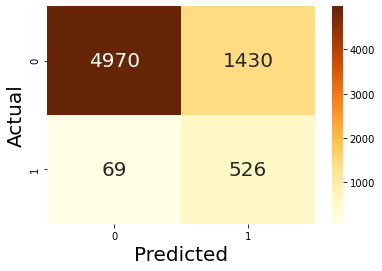

In [37]:
LR(sfm_pi_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.8817401063109042

예측 데이터 정확도
accuracy score : 0.856
precision score : 0.361
recall score : 0.896
f1 score : 0.514
roc score : 0.874
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.78070    0.27696 0.97983   0.43185    0.87101
0.30000   0.78956    0.28515 0.97815   0.44158    0.87509
0.40000   0.79986    0.29433 0.96807   0.45141    0.87614
0.50000   0.85618    0.36087 0.89580   0.51448    0.87415
0.60000   0.85618    0.36087 0.89580   0.51448    0.87415
0.70000   0.86433    0.37465 0.88908   0.52715    0.87555
0.80000   0.88192    0.40253 0.80168   0.53596    0.84553
0.90000   0.91780    0.52273 0.38655   0.44444    0.67687
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

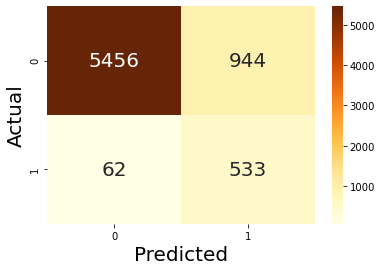

In [38]:
DT(sfm_pi_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8701397490514365

예측 데이터 정확도
accuracy score : 0.794
precision score : 0.286
recall score : 0.953
f1 score : 0.440
roc score : 0.866


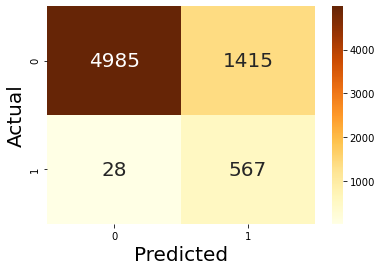

In [39]:
SVM(sfm_pi_bad, 'rbf')

In [ ]:
XGB(sfm_pi_bad)